CT Reconstruction (ADMM Plug-and-Play Priors w/ BM3D, SVMBIR+Prox)
==================================================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve a
tomographic reconstruction problem using the Plug-and-Play Priors framework
<cite data-cite="venkatakrishnan-2013-plugandplay2"/>, using BM3D <cite data-cite="dabov-2008-image"/>
as a denoiser and SVMBIR <cite data-cite="svmbir-2020"/> for tomographic projection.

This version uses the data fidelity term as one of the ADMM g functionals,
and thus the optimization with respect to the data fidelity is able to
exploit the internal prox of the SVMBIRWeightedSquaredL2Loss functional.

In [1]:
import numpy as np

import jax

import matplotlib.pyplot as plt
import svmbir
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import metric, plot
from scico.admm import ADMM, LinearSubproblemSolver
from scico.functional import BM3D, NonNegativeIndicator
from scico.linop import Diagonal, Identity
from scico.linop.radon_svmbir import ParallelBeamProjector, SVMBIRWeightedSquaredL2Loss
plot.config_notebook_plotting()

Generate a ground truth image.

In [2]:
N = 256  # image size
density = 0.025  # attenuation density of the image
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.05, 0.02], gap=0.02, porosity=0.3), size=N - 10)
x_gt = x_gt / np.max(x_gt) * density
x_gt = np.pad(x_gt, 5)
x_gt[x_gt < 0] = 0

Generate tomographic projector and sinogram.

In [3]:
num_angles = int(N / 2)
num_channels = N
angles = snp.linspace(0, snp.pi, num_angles, dtype=snp.float32)
A = ParallelBeamProjector(x_gt.shape, angles, num_channels)
sino = A @ x_gt

Impose Poisson noise on sinogram. Higher max_intensity means less noise.

In [4]:
max_intensity = 2000
expected_counts = max_intensity * np.exp(-sino)
noisy_counts = np.random.poisson(expected_counts).astype(np.float32)
noisy_counts[noisy_counts == 0] = 1  # deal with 0s
y = -np.log(noisy_counts / max_intensity)

Reconstruct using default prior of SVMBIR <cite data-cite="svmbir-2020"/>.

In [5]:
weights = svmbir.calc_weights(y, weight_type="transmission")

x_mrf = svmbir.recon(
    np.array(y[:, np.newaxis]),
    np.array(angles),
    weights=weights[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
)[0]

Set up an ADMM solver.

In [6]:
y, x0, weights = jax.device_put([y, x_mrf, weights])

ρ = 10  # ADMM penalty parameter
σ = density * 0.26  # denoiser sigma

weight_op = Diagonal(weights ** 0.5)

f = SVMBIRWeightedSquaredL2Loss(y=y, A=A, weight_op=weight_op, scale=0.5)
g0 = σ * ρ * BM3D()
g1 = NonNegativeIndicator()

solver = ADMM(
    f=None,
    g_list=[f, g0, g1],
    C_list=[Identity(x_mrf.shape), Identity(x_mrf.shape), Identity(x_mrf.shape)],
    rho_list=[ρ, ρ, ρ],
    x0=x0,
    maxiter=20,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 100}),
    verbose=True,
)

x_bm3d = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Iter  Time      Primal Rsdl  Dual Rsdl
--------------------------------------
   0   5.0e+00    5.158e-01  5.158e-01


   1   8.4e+00    3.427e-01  3.128e-01


   2   1.1e+01    2.178e-01  2.125e-01


   3   1.5e+01    1.314e-01  1.821e-01


   4   1.8e+01    9.776e-02  1.343e-01


   5   2.1e+01    8.852e-02  8.726e-02


   6   2.5e+01    7.593e-02  5.760e-02


   7   2.8e+01    5.815e-02  4.834e-02


   8   3.1e+01    4.232e-02  4.427e-02


   9   3.5e+01    3.333e-02  3.776e-02


  10   3.8e+01    3.047e-02  3.040e-02


  11   4.2e+01    2.802e-02  2.416e-02


  12   4.5e+01    2.540e-02  2.125e-02


  13   4.8e+01    2.197e-02  1.967e-02


  14   5.1e+01    1.996e-02  1.838e-02


  15   5.4e+01    1.871e-02  1.668e-02


  16   5.8e+01    1.752e-02  1.503e-02


  17   6.1e+01    1.711e-02  1.478e-02


  18   6.4e+01    1.623e-02  1.425e-02


  19   6.8e+01    1.501e-02  1.313e-02


Show the recovered image.

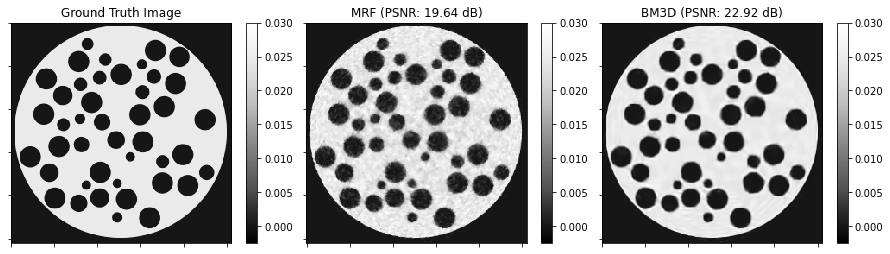

In [7]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1 * density, vmax=1.2 * density)
fig, ax = plt.subplots(1, 3, figsize=[15, 5])
plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0], norm=norm)
plot.imview(
    img=x_mrf,
    title=f"MRF (PSNR: {metric.psnr(x_gt, x_mrf):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
plot.imview(
    img=x_bm3d,
    title=f"BM3D (PSNR: {metric.psnr(x_gt, x_bm3d):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[2],
    norm=norm,
)
fig.show()

Plot convergence statistics.

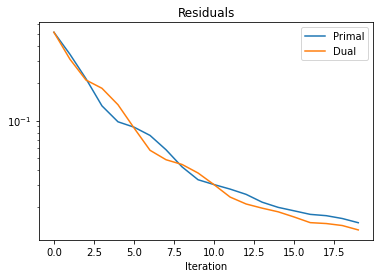

In [8]:
plot.plot(
    snp.vstack((hist.Primal_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)